In [79]:
import time
import torch
import zipfile
import collections
from torch import nn

In [80]:
!wget http://www.manythings.org/anki/fra-eng.zip

--2019-11-28 09:38:55--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5800008 (5.5M) [application/zip]
Saving to: ‘fra-eng.zip.1’

fra-eng.zip.1       100%[===================>]   5.53M  5.96MB/s    in 0.9s    

2019-11-28 09:38:56 (5.96 MB/s) - ‘fra-eng.zip.1’ saved [5800008/5800008]



In [81]:
with zipfile.ZipFile("fra-eng.zip", 'r') as f:
    raw_text = f.read('fra.txt').decode("utf-8")
print(raw_text[0:95])

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
Hi.	Sa


In [82]:
def preprocess_raw(text):
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    out = ''
    for i, char in enumerate(text.lower()):
        if char in (',', '!', '.') and i > 0 and text[i-1] != ' ':
            out += ' '
        out += char
    return out

text = preprocess_raw(raw_text)
print(text[0:95])

go .	va !	cc-by 2 .0 (france) attribution: tatoeba .org #2877272 (cm) & #1158250 (wittydev)
hi 


In [83]:
text[:200]

'go .\tva !\tcc-by 2 .0 (france) attribution: tatoeba .org #2877272 (cm) & #1158250 (wittydev)\nhi .\tsalut !\tcc-by 2 .0 (france) attribution: tatoeba .org #538123 (cm) & #509819 (aiji)\nhi .\tsalut .\tcc-by '

In [84]:
num_examples = 1000
source, target = [], []
for i, line in enumerate(text.split('\n')):
    if i > num_examples:
        break
    parts = line.split('\t')
    if len(parts) == 3:
        source.append(parts[0].split(' '))
        target.append(parts[1].split(' '))

source[0:3], target[0:3]

([['go', '.'], ['hi', '.'], ['hi', '.']],
 [['va', '!'], ['salut', '!'], ['salut', '.']])

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt

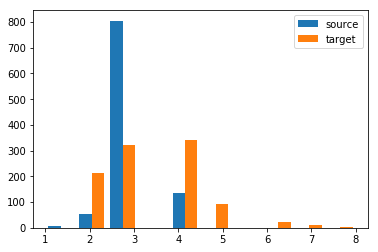

In [86]:
plt.hist([[len(l) for l in source], [len(l) for l in target]],
             label=['source', 'target'])
plt.legend(loc='upper right')
plt.show()

In [87]:
class Vocab(object):
    def __init__(self, tokens, min_freq=0, use_special_tokens=False):
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[0])
        self.token_freqs.sort(key=lambda x: x[1], reverse=True)
        if use_special_tokens:
            self.pad, self.bos, self.eos, self.unk = (0, 1, 2, 3)
            uniq_tokens = ['<pad>', '<bos>', '<eos>', '<unk>']
        else:
            self.unk, uniq_tokens = 0, ['<unk>']
        uniq_tokens +=  [token for token, freq in self.token_freqs 
                         if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1
            
    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

In [88]:
def build_vocab(tokens):
    tokens = [token for line in tokens for token in line]
    return Vocab(tokens, min_freq=3, use_special_tokens=True)

src_vocab = build_vocab(source)
len(src_vocab)

178

In [89]:
def pad(line, max_len, padding_token):
    if len(line) > max_len:
        return line[:max_len]
    return line + [padding_token] * (max_len - len(line))

pad(src_vocab[source[0]], 10, src_vocab.pad)

[9, 4, 0, 0, 0, 0, 0, 0, 0, 0]

In [115]:
def build_array(lines, vocab, max_len, is_source, build_mask=False):
    lines = [vocab[line] for line in lines]
    if not is_source:
        lines = [[vocab.bos] + line + [vocab.eos] for line in lines]
    array = torch.LongTensor([pad(line, max_len, vocab.pad) for line in lines])
    valid_len = (array != vocab.pad).sum(axis=1)
    
    if build_mask:
        mask = torch.zeros_like(array).type(torch.float)
        for i in range(len(valid_len)):
            mask[i, :valid_len[i]]=1.
        return array, valid_len, mask

    return array, valid_len

In [116]:
def load_data_nmt(batch_size, max_len): 
    src_vocab, tgt_vocab = build_vocab(source), build_vocab(target)
    src_array, src_valid_len = build_array(source, src_vocab, max_len, True, False)
    tgt_array, tgt_valid_len, tgt_mask = build_array(target, tgt_vocab, max_len, False, True)
    train_data = torch.utils.data.TensorDataset(
        src_array, src_valid_len, tgt_array, tgt_valid_len, tgt_mask)
    train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
    return src_vocab, tgt_vocab, train_iter

In [117]:
src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size=2, max_len=8)
for X, X_valid_len, Y, Y_valid_len, y_mask in train_iter:
    print('X =', X.type(torch.int), '\nValid lengths for X =', X_valid_len,
          '\nY =', Y.type(torch.int), '\nValid lengths for Y =', Y_valid_len,
          '\nY mask =', y_mask)
    break

X = tensor([[101,  14,   6,   0,   0,   0,   0,   0],
        [ 29,  12,  52,   4,   0,   0,   0,   0]], dtype=torch.int32) 
Valid lengths for X = tensor([3, 4]) 
Y = tensor([[ 1, 21,  3,  5,  2,  0,  0,  0],
        [ 1, 56,  3,  4,  2,  0,  0,  0]], dtype=torch.int32) 
Valid lengths for Y = tensor([5, 5]) 
Y mask = tensor([[1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.]])


In [93]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers

    def forward(self, X, *args):
        X = self.embedding(X) 
        X = X.permute(1, 0, 2)
        state = (torch.zeros((self.num_layers, X.shape[1],self.num_hiddens)), torch.zeros((self.num_layers, X.shape[1],self.num_hiddens)))
        out, state = self.rnn(X, state)
        return out, state

In [94]:
encoder = Encoder(vocab_size=10, embed_size=8,
                         num_hiddens=16, num_layers=2)
X = torch.zeros((4, 7)).type(torch.long)
output, state = encoder(X)
output.shape, len(state), state[0].shape, state[1].shape

(torch.Size([7, 4, 16]), 2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

In [95]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        self.num_hiddens = num_hiddens
        self.embed_size = embed_size
        self.vocab_size = vocab_size

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        out, state = self.rnn(X, state)
        out = self.dense(out.view(-1, self.num_hiddens)).view(out.shape[0], out.shape[1], self.vocab_size).permute(1, 0, 2)
        return out, state

In [96]:
decoder = Decoder(vocab_size=10, embed_size=8,
                         num_hiddens=16, num_layers=2)
state = decoder.init_state(encoder(X))
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, state[1].shape

(torch.Size([4, 7, 10]), 2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

In [97]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

In [131]:
def train(model, data_iter, lr, num_epochs, out_vocab_size):
    trainer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss(reduction='none')
    tic = time.time()
    for epoch in range(1, num_epochs+1):
        l_sum, num_tokens_sum = 0.0, 0.0
        for batch in data_iter:
            X, X_vlen, Y, Y_vlen, mask = [x for x in batch]
            Y_input, Y_label, Y_vlen, mask = Y[:,:-1], Y[:,1:], Y_vlen-1, mask[:,1:]
            Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
            
            
            l = (loss(Y_hat.reshape(-1,out_vocab_size), Y_label.reshape(-1)) * mask.reshape(-1)).sum() 
            
            
            l.backward()
            num_tokens = Y_vlen.sum().item()
            trainer.step()
            l_sum += l.item()
            num_tokens_sum += num_tokens

        print("epoch %d, loss %.3f, time %.1f sec" % (
            epoch, l_sum/num_tokens_sum, time.time()-tic))
        tic = time.time()

In [136]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, max_len = 64, 10
lr, num_epochs = 0.0001, 300

src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size, max_len)
encoder = Encoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Decoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = EncoderDecoder(encoder, decoder)
train(model, train_iter, lr, num_epochs, len(tgt_vocab))

epoch 1, loss 5.050, time 0.4 sec
epoch 2, loss 5.032, time 0.4 sec
epoch 3, loss 5.010, time 0.4 sec
epoch 4, loss 4.983, time 0.4 sec
epoch 5, loss 4.951, time 0.3 sec
epoch 6, loss 4.908, time 0.4 sec
epoch 7, loss 4.851, time 0.4 sec
epoch 8, loss 4.774, time 0.4 sec
epoch 9, loss 4.675, time 0.4 sec
epoch 10, loss 4.552, time 0.4 sec
epoch 11, loss 4.409, time 0.4 sec
epoch 12, loss 4.254, time 0.4 sec
epoch 13, loss 4.098, time 0.4 sec
epoch 14, loss 3.948, time 0.4 sec
epoch 15, loss 3.807, time 0.4 sec
epoch 16, loss 3.679, time 0.4 sec
epoch 17, loss 3.562, time 0.4 sec
epoch 18, loss 3.460, time 0.4 sec
epoch 19, loss 3.371, time 0.4 sec
epoch 20, loss 3.296, time 0.4 sec
epoch 21, loss 3.230, time 0.4 sec
epoch 22, loss 3.175, time 0.4 sec
epoch 23, loss 3.128, time 0.3 sec
epoch 24, loss 3.085, time 0.4 sec
epoch 25, loss 3.047, time 0.4 sec
epoch 26, loss 3.016, time 0.4 sec
epoch 27, loss 2.988, time 0.4 sec
epoch 28, loss 2.957, time 0.4 sec
epoch 29, loss 2.927, time 0.

epoch 232, loss 2.167, time 0.4 sec
epoch 233, loss 2.165, time 0.4 sec
epoch 234, loss 2.162, time 0.5 sec
epoch 235, loss 2.158, time 0.4 sec
epoch 236, loss 2.155, time 0.5 sec
epoch 237, loss 2.153, time 0.4 sec
epoch 238, loss 2.152, time 0.4 sec
epoch 239, loss 2.151, time 0.4 sec
epoch 240, loss 2.150, time 0.5 sec
epoch 241, loss 2.149, time 0.4 sec
epoch 242, loss 2.147, time 0.4 sec
epoch 243, loss 2.146, time 0.4 sec
epoch 244, loss 2.144, time 0.4 sec
epoch 245, loss 2.143, time 0.4 sec
epoch 246, loss 2.141, time 0.5 sec
epoch 247, loss 2.139, time 0.4 sec
epoch 248, loss 2.137, time 0.4 sec
epoch 249, loss 2.135, time 0.4 sec
epoch 250, loss 2.133, time 0.5 sec
epoch 251, loss 2.131, time 0.4 sec
epoch 252, loss 2.128, time 0.4 sec
epoch 253, loss 2.126, time 0.4 sec
epoch 254, loss 2.124, time 0.4 sec
epoch 255, loss 2.121, time 0.4 sec
epoch 256, loss 2.119, time 0.5 sec
epoch 257, loss 2.116, time 0.4 sec
epoch 258, loss 2.113, time 0.4 sec
epoch 259, loss 2.110, time 

In [137]:
def translate(model, src_sentence, src_vocab, tgt_vocab, max_len):
    src_tokens = src_vocab[src_sentence.lower().split(' ')]
    src_len = len(src_tokens)
    if src_len < max_len:
        src_tokens += [src_vocab.pad] * (max_len - src_len)
    enc_X = torch.LongTensor(src_tokens)
    enc_valid_length = torch.LongTensor([src_len])
    enc_outputs = model.encoder(enc_X.unsqueeze(axis=0), enc_valid_length)
    dec_state = model.decoder.init_state(enc_outputs, enc_valid_length)
    dec_X = torch.LongTensor([tgt_vocab.bos]).unsqueeze(axis=0)
    predict_tokens = []
    for _ in range(max_len):
        Y, dec_state = model.decoder(dec_X, dec_state)
        dec_X = Y.argmax(axis=2)
        py = dec_X.squeeze(axis=0).type(torch.long).item()
        if py == tgt_vocab.eos:
            break
        predict_tokens.append(py)
    return ' '.join(tgt_vocab.to_tokens(predict_tokens))

In [138]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + translate(
        model, sentence, src_vocab, tgt_vocab, max_len))

Go . => je <unk> .
Wow ! => je <unk> .
I'm OK . => je <unk> .
I won ! => je <unk> .


In [139]:
train(model, train_iter, lr, num_epochs, len(tgt_vocab))

epoch 1, loss 2.042, time 0.4 sec
epoch 2, loss 2.041, time 0.4 sec
epoch 3, loss 2.040, time 0.4 sec
epoch 4, loss 2.038, time 0.4 sec
epoch 5, loss 2.035, time 0.4 sec
epoch 6, loss 2.033, time 0.4 sec
epoch 7, loss 2.031, time 0.4 sec
epoch 8, loss 2.030, time 0.4 sec
epoch 9, loss 2.028, time 0.4 sec
epoch 10, loss 2.027, time 0.4 sec
epoch 11, loss 2.026, time 0.4 sec
epoch 12, loss 2.025, time 0.4 sec
epoch 13, loss 2.024, time 0.4 sec
epoch 14, loss 2.024, time 0.4 sec
epoch 15, loss 2.022, time 0.4 sec
epoch 16, loss 2.021, time 0.4 sec
epoch 17, loss 2.019, time 0.4 sec
epoch 18, loss 2.017, time 0.4 sec
epoch 19, loss 2.014, time 0.4 sec
epoch 20, loss 2.011, time 0.4 sec
epoch 21, loss 2.007, time 0.4 sec
epoch 22, loss 2.004, time 0.4 sec
epoch 23, loss 2.001, time 0.4 sec
epoch 24, loss 1.999, time 0.4 sec
epoch 25, loss 1.998, time 0.4 sec
epoch 26, loss 1.996, time 0.4 sec
epoch 27, loss 1.995, time 0.4 sec
epoch 28, loss 1.995, time 0.4 sec
epoch 29, loss 1.994, time 0.

epoch 232, loss 1.837, time 0.4 sec
epoch 233, loss 1.834, time 0.4 sec
epoch 234, loss 1.831, time 0.4 sec
epoch 235, loss 1.830, time 0.4 sec
epoch 236, loss 1.831, time 0.4 sec
epoch 237, loss 1.835, time 0.4 sec
epoch 238, loss 1.838, time 0.4 sec
epoch 239, loss 1.842, time 0.4 sec
epoch 240, loss 1.843, time 0.4 sec
epoch 241, loss 1.840, time 0.4 sec
epoch 242, loss 1.834, time 0.5 sec
epoch 243, loss 1.825, time 0.5 sec
epoch 244, loss 1.817, time 0.5 sec
epoch 245, loss 1.811, time 0.4 sec
epoch 246, loss 1.809, time 0.5 sec
epoch 247, loss 1.811, time 0.5 sec
epoch 248, loss 1.816, time 0.4 sec
epoch 249, loss 1.821, time 0.4 sec
epoch 250, loss 1.827, time 0.4 sec
epoch 251, loss 1.834, time 0.4 sec
epoch 252, loss 1.839, time 0.4 sec
epoch 253, loss 1.842, time 0.4 sec
epoch 254, loss 1.844, time 0.4 sec
epoch 255, loss 1.845, time 0.4 sec
epoch 256, loss 1.843, time 0.4 sec
epoch 257, loss 1.840, time 0.4 sec
epoch 258, loss 1.836, time 0.4 sec
epoch 259, loss 1.830, time 

In [140]:
train(model, train_iter, lr / 10, num_epochs, len(tgt_vocab))

epoch 1, loss 1.826, time 0.4 sec
epoch 2, loss 1.826, time 0.4 sec
epoch 3, loss 1.825, time 0.4 sec
epoch 4, loss 1.824, time 0.4 sec
epoch 5, loss 1.823, time 0.4 sec
epoch 6, loss 1.822, time 0.4 sec
epoch 7, loss 1.821, time 0.4 sec
epoch 8, loss 1.820, time 0.4 sec
epoch 9, loss 1.819, time 0.4 sec
epoch 10, loss 1.817, time 0.4 sec
epoch 11, loss 1.816, time 0.4 sec
epoch 12, loss 1.815, time 0.4 sec
epoch 13, loss 1.814, time 0.4 sec
epoch 14, loss 1.812, time 0.4 sec
epoch 15, loss 1.811, time 0.4 sec
epoch 16, loss 1.810, time 0.4 sec
epoch 17, loss 1.809, time 0.4 sec
epoch 18, loss 1.807, time 0.4 sec
epoch 19, loss 1.806, time 0.4 sec
epoch 20, loss 1.805, time 0.4 sec
epoch 21, loss 1.804, time 0.4 sec
epoch 22, loss 1.802, time 0.5 sec
epoch 23, loss 1.801, time 0.4 sec
epoch 24, loss 1.800, time 0.4 sec
epoch 25, loss 1.799, time 0.4 sec
epoch 26, loss 1.797, time 0.4 sec
epoch 27, loss 1.796, time 0.4 sec
epoch 28, loss 1.795, time 0.4 sec
epoch 29, loss 1.794, time 0.

epoch 232, loss 1.747, time 0.4 sec
epoch 233, loss 1.747, time 0.4 sec
epoch 234, loss 1.747, time 0.4 sec
epoch 235, loss 1.747, time 0.4 sec
epoch 236, loss 1.747, time 0.4 sec
epoch 237, loss 1.747, time 0.4 sec
epoch 238, loss 1.747, time 0.4 sec
epoch 239, loss 1.747, time 0.4 sec
epoch 240, loss 1.747, time 0.4 sec
epoch 241, loss 1.747, time 0.4 sec
epoch 242, loss 1.747, time 0.4 sec
epoch 243, loss 1.747, time 0.4 sec
epoch 244, loss 1.747, time 0.4 sec
epoch 245, loss 1.747, time 0.4 sec
epoch 246, loss 1.747, time 0.4 sec
epoch 247, loss 1.747, time 0.4 sec
epoch 248, loss 1.748, time 0.4 sec
epoch 249, loss 1.748, time 0.4 sec
epoch 250, loss 1.748, time 0.4 sec
epoch 251, loss 1.748, time 0.4 sec
epoch 252, loss 1.748, time 0.4 sec
epoch 253, loss 1.747, time 0.4 sec
epoch 254, loss 1.747, time 0.4 sec
epoch 255, loss 1.747, time 0.4 sec
epoch 256, loss 1.747, time 0.4 sec
epoch 257, loss 1.747, time 0.4 sec
epoch 258, loss 1.747, time 0.4 sec
epoch 259, loss 1.747, time 

In [141]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + translate(
        model, sentence, src_vocab, tgt_vocab, max_len))

Go . => <unk> !
Wow ! => <unk> !
I'm OK . => je suis <unk> .
I won ! => je suis <unk> .
